In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import tensorflow.experimental.numpy as tfnp
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Load data
train_ds = xr.open_dataset("/glade/scratch/lverhoef/gdl_toy_ds/train_data.nc")
validation_ds = xr.open_dataset("/glade/scratch/lverhoef/gdl_toy_ds/validation_data.nc")

In [5]:
X_train = tf.expand_dims(tf.convert_to_tensor(train_ds['ellipse']), axis=-1)
Y_train = tf.convert_to_tensor(train_ds['angle'])

In [7]:
X_val = tf.expand_dims(tf.convert_to_tensor(validation_ds['ellipse']), axis=-1)
Y_val = tf.convert_to_tensor(validation_ds['angle'])

In [8]:
# Layer that implements 4 discrete rotational equivariance
# Note that this uses group convolution on Z^2 x C_4, where rotation is about the center of the domain.
class RotEquivConv2D(tf.keras.layers.Layer):
    def __init__(
            self,
            out_features,
            filt_shape, 
            rot_axis=True,
            activation=tf.nn.relu,
            use_bias=True,
            kernel_initializer=tf.keras.initializers.glorot_uniform,
            bias_initializer=tf.keras.initializers.zeros,
            **kwargs):
        super().__init__(**kwargs)
        self.out_features = out_features
        self.filt_shape = filt_shape
        self.rot_axis = rot_axis
        self.activation = activation
        self.use_bias = use_bias
        self.kernel_initializer = kernel_initializer()
        if use_bias:
            self.bias_initializer = bias_initializer()

    def build(self, input_shape):  # Create the layer when it is first called
        self.in_features = input_shape[-1]
        self.filt_shape = tf.concat([
            self.filt_shape,  # Spatial dimensions
            [self.in_features, self.out_features]
        ], axis=0)
        self.filt_base = tf.Variable(
            self.kernel_initializer(self.filt_shape),  # Random initialization of filters
            name='kernel'
        )
        if self.use_bias:
            self.bias = tf.Variable(self.bias_initializer((self.out_features,)), name='bias')

    def call(self, inputs):  # Does the actual computation for each rotation
        if self.rot_axis:  # If we're already in Z^2 x C_4, convolve along each rotational layer
            outputs = self.activation(tf.stack([
                    tf.nn.convolution(
                        tfnp.take(inputs, i, axis=-2),
                        self.filt_base)
                    for i in range(inputs.shape[-2])],
                axis=-2
            ))
        else:  # If we're not yet in the group domain, move to it.
            outputs = self.activation(tf.stack([
                tf.nn.convolution(inputs, self.filt_base),
                tfnp.rot90(tf.nn.convolution(inputs, tfnp.rot90(self.filt_base, k=1)), k=4-1, axes=(1, 2)),
                tfnp.rot90(tf.nn.convolution(inputs, tfnp.rot90(self.filt_base, k=2)), k=4-2, axes=(1, 2)),
                tfnp.rot90(tf.nn.convolution(inputs, tfnp.rot90(self.filt_base, k=3)), k=4-3, axes=(1, 2)),
            ], axis=-2))
        if self.use_bias:
            outputs = tf.nn.bias_add(outputs, self.bias)
        return outputs

In [9]:
# 2D pooling layer that pools within each rotational dimension
class RotEquivPool2D(tf.keras.layers.Layer):
    def __init__(self, pool_size, pool_method=tf.keras.layers.MaxPool2D, **kwargs):
        super().__init__(**kwargs)
        self.pool_size = pool_size
        self.pool_method = pool_method
        self.pool = self.pool_method(pool_size=self.pool_size)

    def call(self, inputs):
        return tf.stack(
            [self.pool(tfnp.take(inputs, k, axis=-2)) for k in range(inputs.shape[-2])],
            axis=-2
        )

In [10]:
# Rotational invariant pooling that pools across the rotational dimensions
class RotInvPool(tf.keras.layers.Layer):
    def __init__(self, pool_method='max', **kwargs):
        valid_methods = {'max', 'mean'}
        if pool_method not in valid_methods:
            raise ValueError(f'pool_method must be one of {valid_methods}')

        super().__init__(**kwargs)
        if pool_method == "max":
            self.pool_method = tf.math.reduce_max
        else:
            self.pool_method = tf.math.reduce_mean

    def call(self, inputs):
        return self.pool_method(inputs, axis=-2)

In [45]:
model = models.Sequential()
model.add(RotEquivConv2D(32, (3, 3), rot_axis=False, input_shape=(128, 128, 1)))
model.add(RotEquivPool2D((2, 2)))
model.add(RotEquivConv2D(32, (3, 3)))
model.add(RotEquivPool2D((2, 2)))
model.add(RotEquivConv2D(64, (3, 3)))
model.add(RotEquivPool2D((2, 2)))
model.add(RotEquivConv2D(64, (3, 3)))
model.add(RotEquivPool2D((2, 2)))
model.add(RotEquivConv2D(53, (3, 3)))
# model.add(RotInvPool())  # Removed to get an equivariant model rather than an invariant one.
model.add(layers.Flatten())
model.add(layers.Dense(32))
model.add(layers.Dense(1))

In [46]:
model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mse']
)

In [47]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rot_equiv_conv2d_35 (RotEqu  (None, 126, 126, 4, 32)  320       
 ivConv2D)                                                       
                                                                 
 rot_equiv_pool2d_28 (RotEqu  (None, 63, 63, 4, 32)    0         
 ivPool2D)                                                       
                                                                 
 rot_equiv_conv2d_36 (RotEqu  (None, 61, 61, 4, 32)    9248      
 ivConv2D)                                                       
                                                                 
 rot_equiv_pool2d_29 (RotEqu  (None, 30, 30, 4, 32)    0         
 ivPool2D)                                                       
                                                                 
 rot_equiv_conv2d_37 (RotEqu  (None, 28, 28, 4, 64)   

In [48]:
history = model.fit(
    x=X_train, y=Y_train,
    epochs=10, validation_data=(X_val, Y_val),
    shuffle=True
)

Epoch 1/10
313/313 [==============================] - 22s 57ms/step - loss: 0.6167 - mse: 0.6167 - val_loss: 0.4246 - val_mse: 0.4246
Epoch 2/10
313/313 [==============================] - 18s 56ms/step - loss: 0.3251 - mse: 0.3251 - val_loss: 0.1776 - val_mse: 0.1776
Epoch 3/10
313/313 [==============================] - 17s 55ms/step - loss: 0.1797 - mse: 0.1797 - val_loss: 0.1159 - val_mse: 0.1159
Epoch 4/10
313/313 [==============================] - 17s 55ms/step - loss: 0.1354 - mse: 0.1354 - val_loss: 0.0812 - val_mse: 0.0812
Epoch 5/10
313/313 [==============================] - 17s 55ms/step - loss: 0.1117 - mse: 0.1117 - val_loss: 0.1031 - val_mse: 0.1031
Epoch 6/10
313/313 [==============================] - 18s 56ms/step - loss: 0.0994 - mse: 0.0994 - val_loss: 0.1216 - val_mse: 0.1216
Epoch 7/10
313/313 [==============================] - 17s 55ms/step - loss: 0.0816 - mse: 0.0816 - val_loss: 0.0717 - val_mse: 0.0717
Epoch 8/10
313/313 [==============================] - 17s 55ms

In [15]:
CNN_model = models.Sequential()
CNN_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)))
CNN_model.add(layers.MaxPooling2D((2, 2)))
CNN_model.add(layers.Conv2D(32, (3, 3), activation='relu'))
CNN_model.add(layers.MaxPooling2D((2, 2)))
CNN_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
CNN_model.add(layers.MaxPooling2D((2, 2)))
CNN_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
CNN_model.add(layers.MaxPooling2D((2, 2)))
CNN_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
CNN_model.add(layers.Flatten())
CNN_model.add(layers.Dense(32, activation='relu'))
CNN_model.add(layers.Dense(1))

In [16]:
CNN_model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mse']
)

In [29]:
CNN_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      320       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 32)        9248      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 30, 30, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 14, 14, 64)      

In [17]:
CNN_history = CNN_model.fit(
    x=X_train, y=Y_train,
    epochs=10, validation_data=(X_val, Y_val),
    shuffle=True
)

Epoch 1/10
313/313 [==============================] - 4s 10ms/step - loss: 0.7105 - mse: 0.7105 - val_loss: 0.3760 - val_mse: 0.3760
Epoch 2/10
313/313 [==============================] - 3s 10ms/step - loss: 0.4118 - mse: 0.4118 - val_loss: 0.2640 - val_mse: 0.2640
Epoch 3/10
313/313 [==============================] - 3s 10ms/step - loss: 0.2653 - mse: 0.2653 - val_loss: 0.3090 - val_mse: 0.3090
Epoch 4/10
313/313 [==============================] - 3s 10ms/step - loss: 0.2046 - mse: 0.2046 - val_loss: 0.1096 - val_mse: 0.1096
Epoch 5/10
313/313 [==============================] - 3s 10ms/step - loss: 0.1432 - mse: 0.1432 - val_loss: 0.1192 - val_mse: 0.1192
Epoch 6/10
313/313 [==============================] - 3s 10ms/step - loss: 0.1369 - mse: 0.1369 - val_loss: 0.1736 - val_mse: 0.1736
Epoch 7/10
313/313 [==============================] - 4s 12ms/step - loss: 0.1164 - mse: 0.1164 - val_loss: 0.0652 - val_mse: 0.0652
Epoch 8/10
313/313 [==============================] - 3s 10ms/step - 

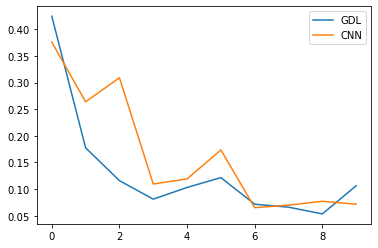

In [49]:
a = plt.plot(history.history['val_mse'], label='GDL')
b = plt.plot(CNN_history.history['val_mse'], label='CNN')
plt.legend()

In [50]:
test_ds = xr.open_dataset("/glade/scratch/lverhoef/gdl_toy_ds/test_data.nc")
X_test = tf.expand_dims(tf.convert_to_tensor(test_ds["ellipse"]), axis=-1)
Y_test = tf.convert_to_tensor(test_ds['angle'])

In [51]:
model.evaluate(X_val, Y_val)
model.evaluate(X_test, Y_test)

32/32 [==============================] - 1s 20ms/step - loss: 0.1222 - mse: 0.1222


[0.12220527231693268, 0.12220527231693268]

In [52]:
CNN_model.evaluate(X_val, Y_val)
CNN_model.evaluate(X_test, Y_test)

32/32 [==============================] - 0s 6ms/step - loss: 0.0998 - mse: 0.0998


[0.09984864294528961, 0.09984864294528961]